# Environment

In [17]:
import torchaudio
import numpy as np
from torch import Tensor
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import find_peaks
from helpers.path_utils import get_base_dir
from helpers.plot import plot_wavelet_spectrogram, plot_audio_fft
from helpers.transform import TrimAfterTrigger, apply_bandpass_filter, min_max_scale

# Raw Heartbeat

Sample rate:  4000


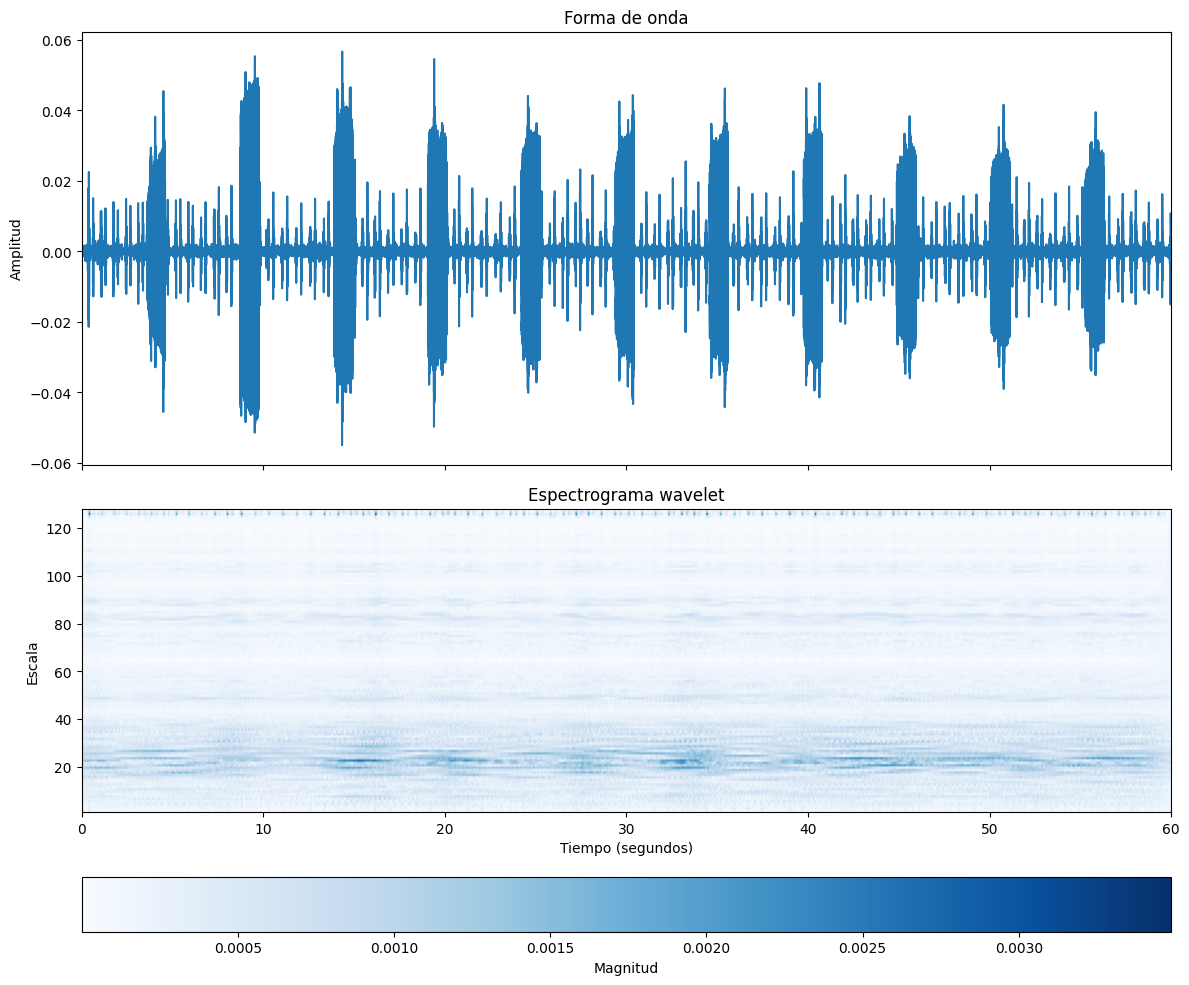

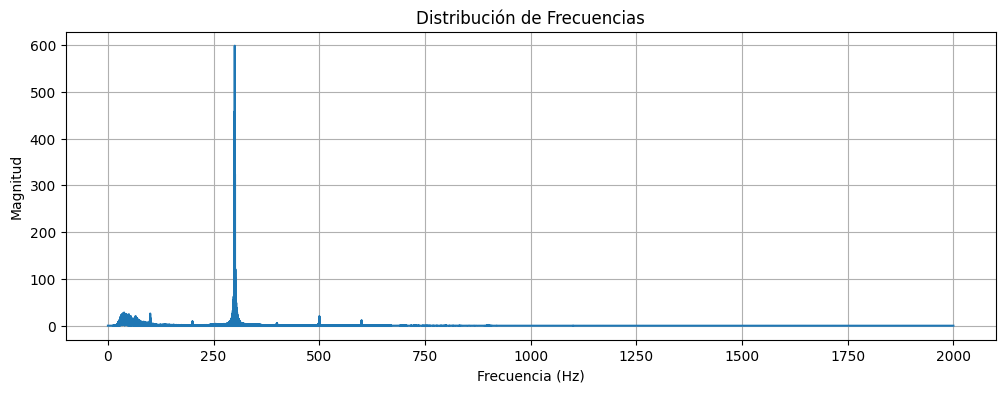

In [26]:
AUDIO_NAME = "test-202407211616.wav"
AUDIO_NAME = "Eko Recording Sound Export 08_17_2024 2_57 PM.wav"
audio_DIR = get_base_dir().joinpath(f"data/digital/{AUDIO_NAME}")

audio, sample_rate = torchaudio.load(str(audio_DIR))
print("Sample rate: ", sample_rate)

plot_wavelet_spectrogram(audio.numpy(), sample_rate)#, downsample_factor=1)
plot_audio_fft(audio.numpy(), sample_rate)

Audio(audio, rate=sample_rate, autoplay=True)

# Focus on synthetic frequency

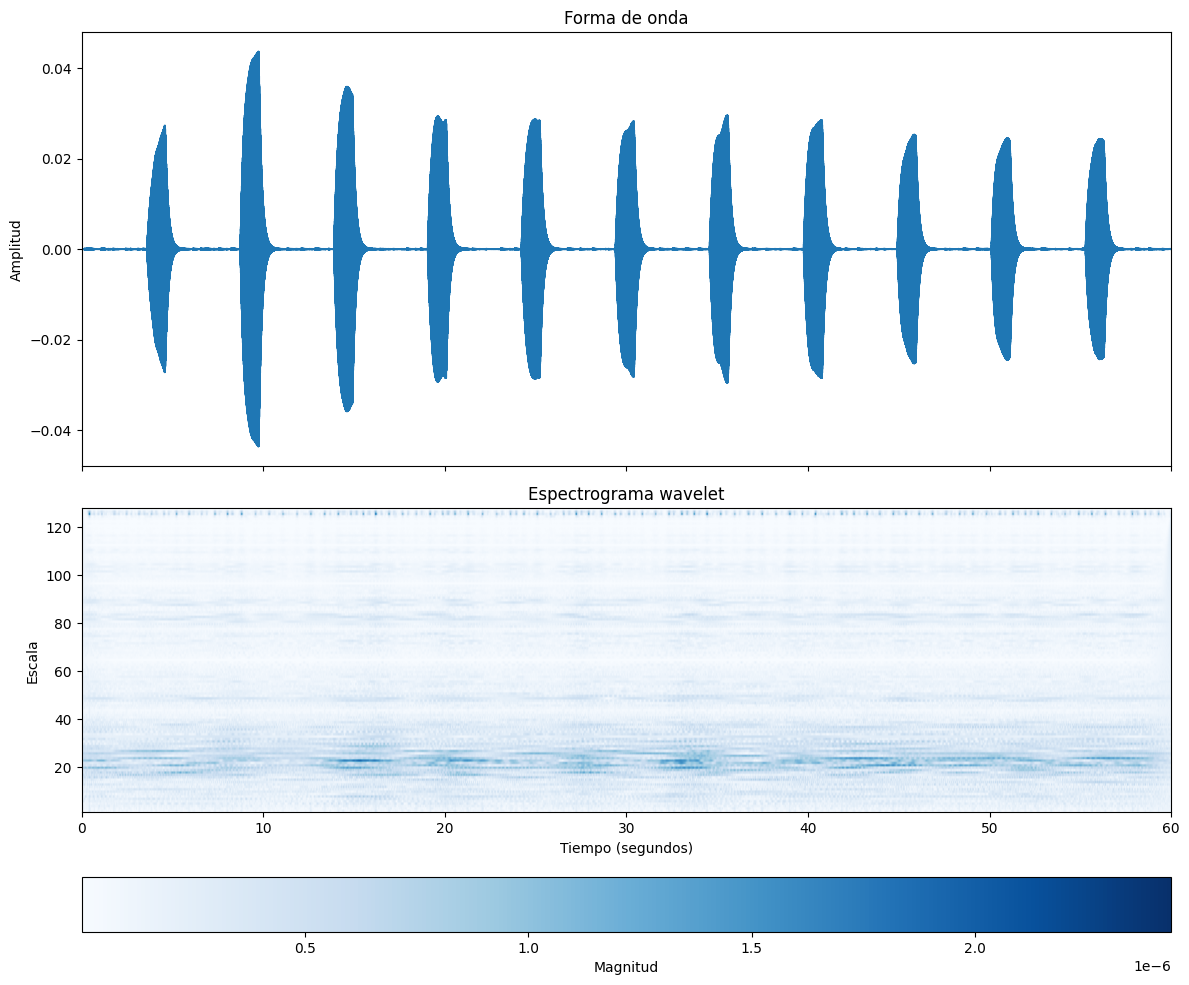

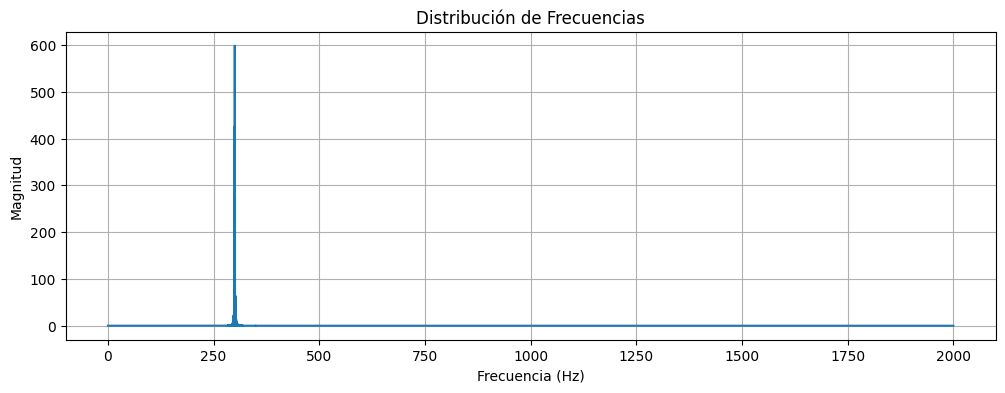

In [27]:
SYNTHETIC_FREQ = 300
low_cutoff = SYNTHETIC_FREQ - 1
high_cutoff = SYNTHETIC_FREQ + 1

filtered_audio = apply_bandpass_filter(
    audio, sample_rate, low_cutoff, high_cutoff
)

plot_wavelet_spectrogram(filtered_audio.numpy(), sample_rate)#, downsample_factor=1)
plot_audio_fft(filtered_audio.numpy(), sample_rate)

Audio(filtered_audio, rate=sample_rate, autoplay=True)

# Downsample and smooth it

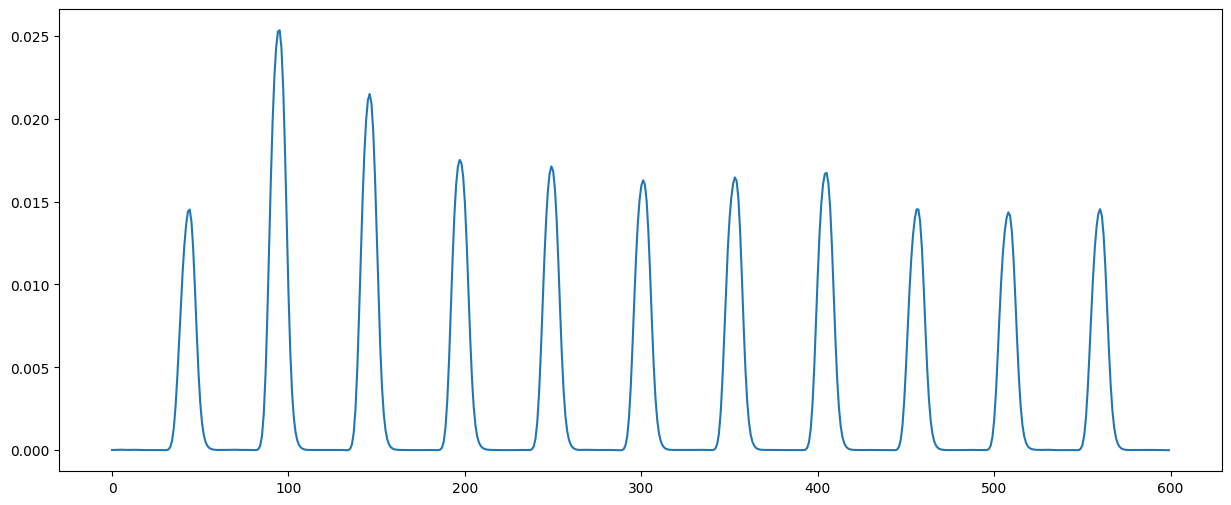

In [28]:
tat = TrimAfterTrigger()
DOWNSAMPLE_FACTOR = 400
SIGMA_SMOOTH = 2

smoothed = tat.abs_downsample_smooth(filtered_audio, DOWNSAMPLE_FACTOR, SIGMA_SMOOTH)
plt.figure(figsize=(15, 6))
plt.plot(smoothed.squeeze())

# Find peaks where signal changes

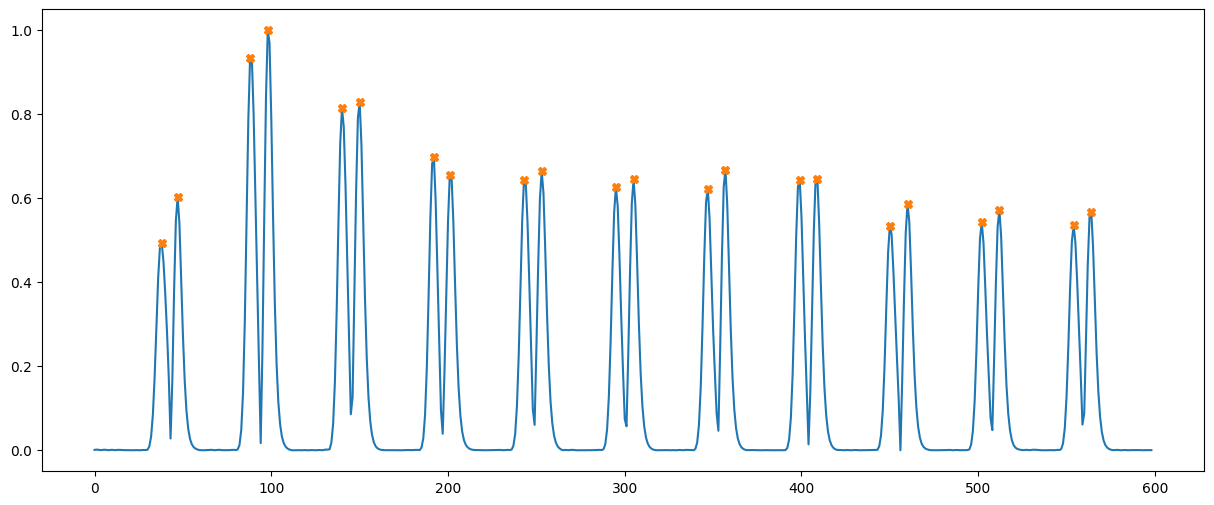

In [29]:
PEAKS_HEIGHT = 0.1
PEAKS_PROMINENCE = 0.0001

smoothed_diff = np.abs(np.diff(smoothed).squeeze())
smoothed_diff = min_max_scale(Tensor(smoothed_diff))
peaks, _ = find_peaks(smoothed_diff, height=PEAKS_HEIGHT, prominence=PEAKS_PROMINENCE)

plt.figure(figsize=(15, 6))
plt.plot(smoothed_diff)
plt.plot(peaks, smoothed_diff[peaks], "X")

# Upsample those peaks in the raw audio signal

Peaks found in downsampled signal: [ 38  47  88  98 140 150 192 201 243 253 295 305 347 357 399 409 450 460
 502 512 554 564]
Peaks in real signal: [ 15200  18800  35200  39200  56000  60000  76800  80400  97200 101200
 118000 122000 138800 142800 159600 163600 180000 184000 200800 204800
 221600 225600]


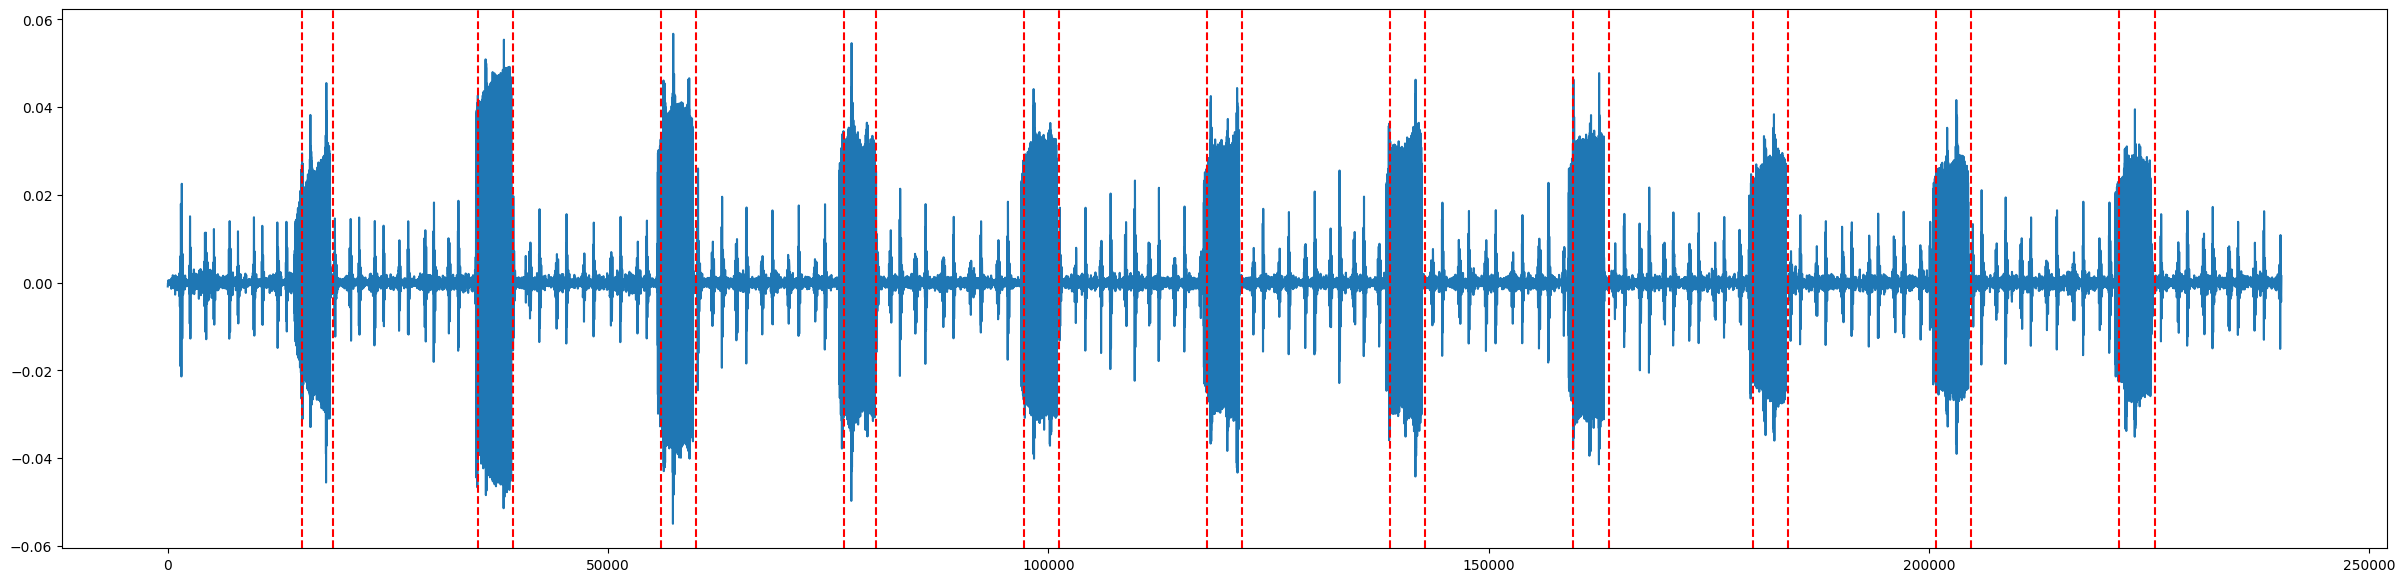

In [30]:
upsampled_peaks = peaks * DOWNSAMPLE_FACTOR
print(f"Peaks found in downsampled signal: {peaks}")
print(f"Peaks in real signal: {upsampled_peaks}")

plt.figure(figsize=(30, 7))
plt.plot(audio.squeeze())

for peak in upsampled_peaks:
    plt.axvline(x=peak, color='red', linestyle='--')

plt.show()

In [34]:
for x in np.diff(upsampled_peaks) / sample_rate:
    print(x)

0.9
4.1
1.0
4.2
1.0
4.2
0.9
4.2
1.0
4.2
1.0
4.2
1.0
4.2
1.0
4.1
1.0
4.2
1.0
4.2
1.0


# Adjust peaks to make sure the trigger is considered

In [35]:
print(f"Peaks: {upsampled_peaks}")

segment_duration = np.diff(upsampled_peaks) / sample_rate
print(f"Duration (without the first one): {segment_duration}")

is_peak_start = np.concatenate([segment_duration < 2, [False]])
is_peak_end = np.concatenate([[False], segment_duration < 2])

peak_starts = upsampled_peaks[is_peak_start]
peak_ends = upsampled_peaks[is_peak_end]

print(f"Peak starts on: {peak_starts}")
print(f"Peak ends on: {peak_ends}")

Peaks: [ 15200  18800  35200  39200  56000  60000  76800  80400  97200 101200
 118000 122000 138800 142800 159600 163600 180000 184000 200800 204800
 221600 225600]
Duration (without the first one): [0.9 4.1 1.  4.2 1.  4.2 0.9 4.2 1.  4.2 1.  4.2 1.  4.2 1.  4.1 1.  4.2
 1.  4.2 1. ]
Peak starts on: [ 15200  35200  56000  76800  97200 118000 138800 159600 180000 200800
 221600]
Peak ends on: [ 18800  39200  60000  80400 101200 122000 142800 163600 184000 204800
 225600]


In [36]:
TRIGGER_DURATION = 0.5
duration_adj = TRIGGER_DURATION + 0.1

trigger_starts = []
trigger_ends = []

for start, end in zip(peak_starts, peak_ends):
    raw_duration = (end - start) / sample_rate
    duration_diff = duration_adj - raw_duration
    half_diff = duration_diff / 2

    to_adjust = half_diff * sample_rate

    trigger_starts.append(start - to_adjust)
    trigger_ends.append(end + to_adjust)

print(f"Trigger starts on: {trigger_starts}")
print(f"Trigger ends on: {trigger_ends}")

new_duration = [(end - start) / sample_rate for start, end in zip(trigger_starts, trigger_ends)]
print(f"With duration adjusted to: {new_duration}")

Trigger starts on: [15800.0, 36000.0, 56800.0, 77400.0, 98000.0, 118800.0, 139600.0, 160400.0, 180800.0, 201600.0, 222400.0]
Trigger ends on: [18200.0, 38400.0, 59200.0, 79800.0, 100400.0, 121200.0, 142000.0, 162800.0, 183200.0, 204000.0, 224800.0]
With duration adjusted to: [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]


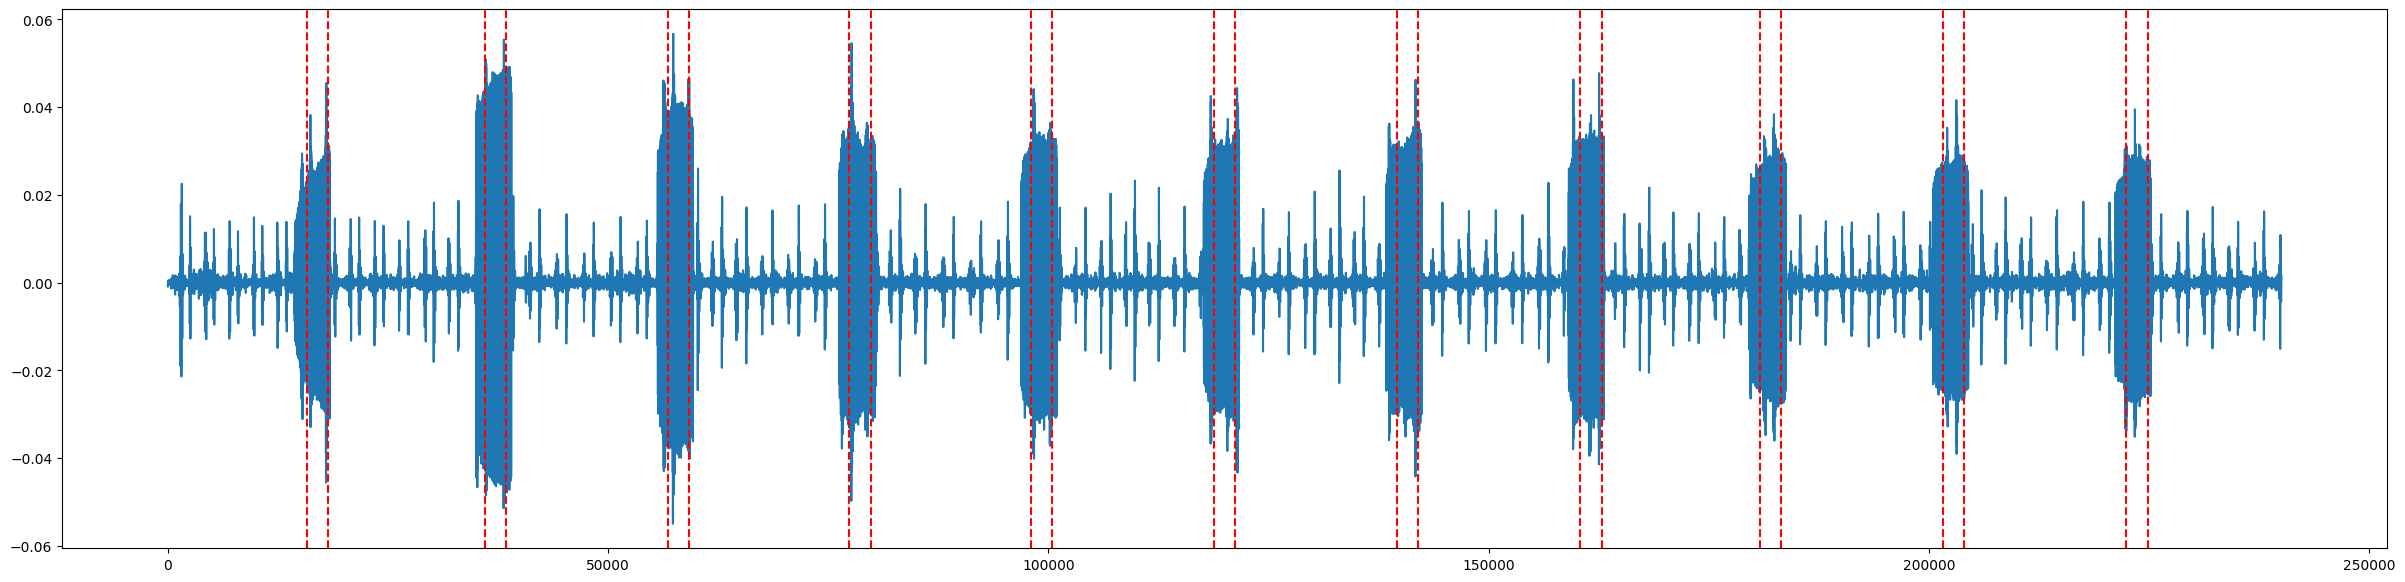

In [37]:
plt.figure(figsize=(30, 7))
plt.plot(audio.squeeze())

for start, end in zip(trigger_starts, trigger_ends):
    plt.axvline(x=start, color='red', linestyle='--')
    plt.axvline(x=end, color='red', linestyle='--')

plt.show()

# Split signal

In [38]:
new_peaks = np.array(sorted(trigger_starts + trigger_ends)).astype(int)
new_peaks

array([ 15800,  18200,  36000,  38400,  56800,  59200,  77400,  79800,
        98000, 100400, 118800, 121200, 139600, 142000, 160400, 162800,
       180800, 183200, 201600, 204000, 222400, 224800])

In [39]:
split_points = np.concatenate(([0], new_peaks, [audio.shape[1]]))

audio_tensor = audio.squeeze()
segments = [
    audio_tensor[split_points[i] : split_points[i + 1]]
    for i in range(len(split_points) - 1)
]

for i, segment in enumerate(segments):
    duration = len(segment) / sample_rate
    to_print = f"#{i+1} ({duration:.2f}s)"

    if duration == duration_adj:
        to_print += " trigger"
    else:
        to_print += " segment"

    to_print += f": {segment}"
    print(to_print)

#1 (3.95s) segment: tensor([-0.0009, -0.0008, -0.0008,  ..., -0.0166, -0.0209, -0.0208])
#2 (0.60s) trigger: tensor([-0.0164, -0.0090,  0.0002,  ..., -0.0231, -0.0283, -0.0268])
#3 (4.45s) segment: tensor([-0.0195, -0.0085,  0.0042,  ..., -0.0070, -0.0232, -0.0339])
#4 (0.60s) trigger: tensor([-0.0378, -0.0348, -0.0251,  ..., -0.0066, -0.0239, -0.0365])
#5 (4.60s) segment: tensor([-0.0423, -0.0399, -0.0291,  ..., -0.0083, -0.0220, -0.0314])
#6 (0.60s) trigger: tensor([-0.0349, -0.0316, -0.0219,  ...,  0.0056, -0.0078, -0.0176])
#7 (4.55s) segment: tensor([-0.0220, -0.0199, -0.0111,  ..., -0.0082, -0.0202, -0.0282])
#8 (0.60s) trigger: tensor([-0.0305, -0.0266, -0.0164,  ..., -0.0060, -0.0171, -0.0250])
#9 (4.55s) segment: tensor([-0.0278, -0.0248, -0.0159,  ..., -0.0085, -0.0188, -0.0251])
#10 (0.60s) trigger: tensor([-0.0264, -0.0220, -0.0122,  ..., -0.0107, -0.0208, -0.0276])
#11 (4.60s) segment: tensor([-0.0296, -0.0261, -0.0172,  ..., -0.0112, -0.0205, -0.0258])
#12 (0.60s) trigger

# Keep just the valid segments

#1 (4.45s): tensor([-0.0195, -0.0085,  0.0042,  ..., -0.0070, -0.0232, -0.0339])


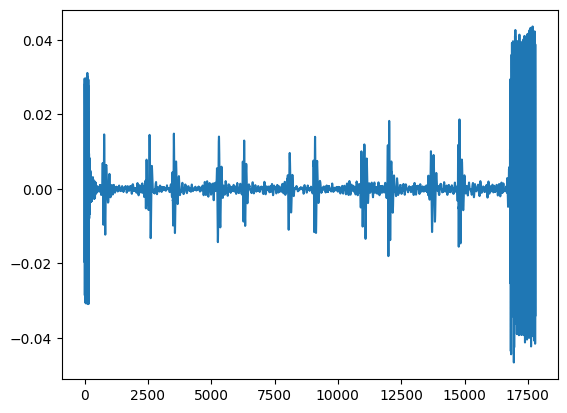

#2 (4.6s): tensor([-0.0423, -0.0399, -0.0291,  ..., -0.0083, -0.0220, -0.0314])


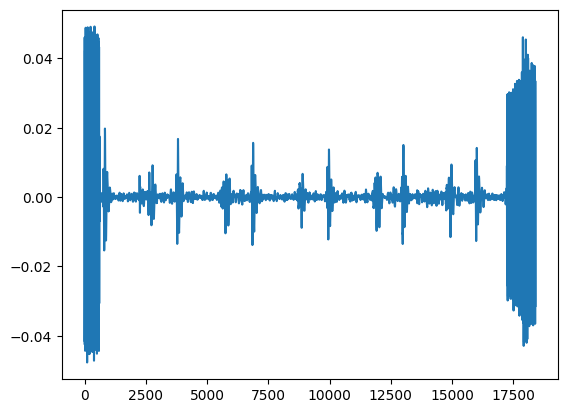

#3 (4.55s): tensor([-0.0220, -0.0199, -0.0111,  ..., -0.0082, -0.0202, -0.0282])


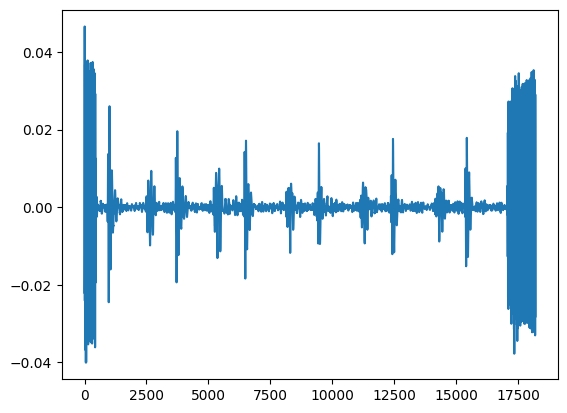

#4 (4.55s): tensor([-0.0278, -0.0248, -0.0159,  ..., -0.0085, -0.0188, -0.0251])


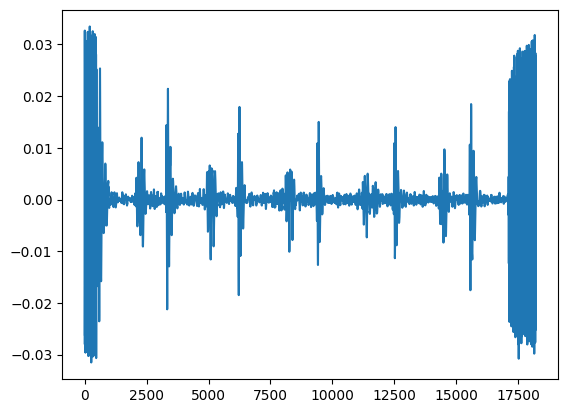

#5 (4.6s): tensor([-0.0296, -0.0261, -0.0172,  ..., -0.0112, -0.0205, -0.0258])


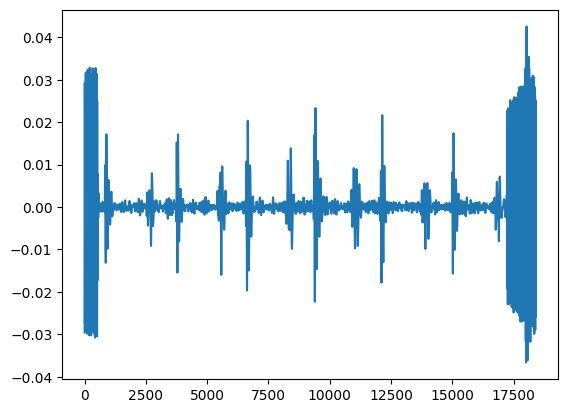

#6 (4.6s): tensor([-0.0289, -0.0240, -0.0136,  ..., -0.0133, -0.0217, -0.0263])


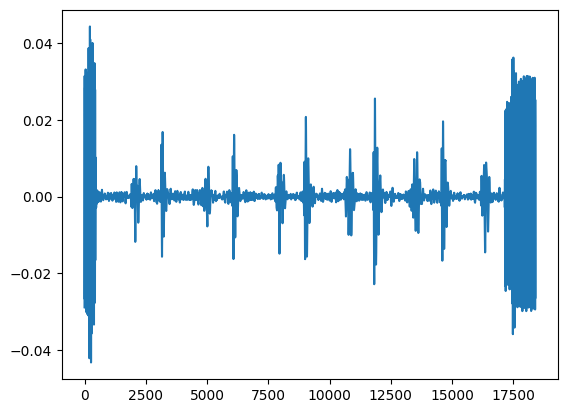

#7 (4.6s): tensor([-0.0287, -0.0225, -0.0110,  ..., -0.0138, -0.0219, -0.0261])


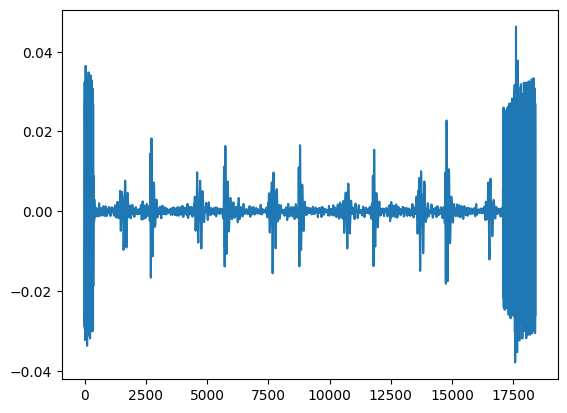

#8 (4.5s): tensor([-0.0286, -0.0221, -0.0107,  ..., -0.0114, -0.0184, -0.0222])


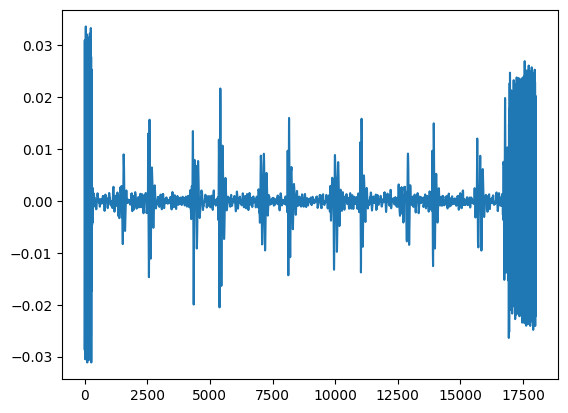

#9 (4.6s): tensor([-0.0238, -0.0172, -0.0061,  ..., -0.0133, -0.0195, -0.0220])


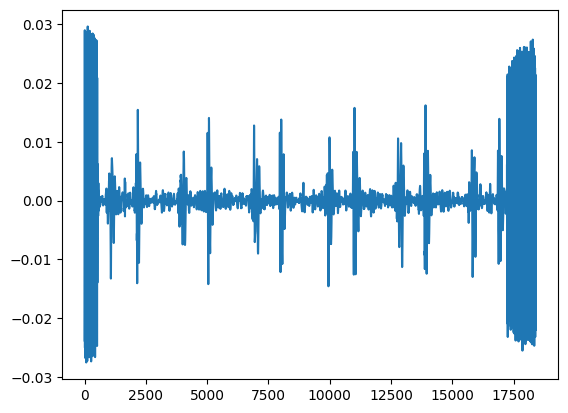

#10 (4.6s): tensor([-0.0208, -0.0139, -0.0029,  ..., -0.0218, -0.0280, -0.0305])


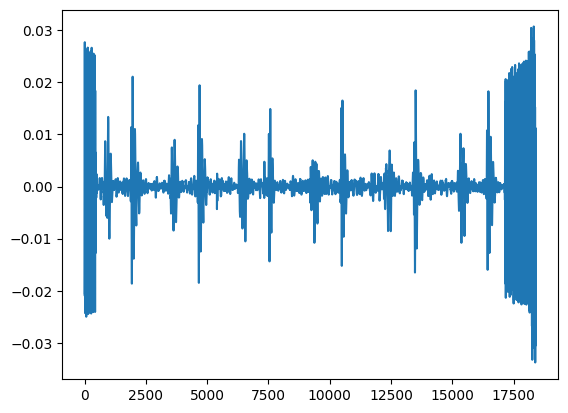

In [40]:
MIN_SECS = 4

filtered_segments = filter(lambda x: len(x) / sample_rate > MIN_SECS, segments)
valid_segments = list(map(lambda x: x.unsqueeze(0), filtered_segments))

for i, segment in enumerate(valid_segments):
    segment = segment.squeeze()
    duration = len(segment) / sample_rate

    print(f"#{i+1} ({duration}s): {segment}")
    plt.plot(segment)
    plt.show()

# All wrapped in one function

In [ ]:
from helpers.transform import TrimAfterTrigger

tat = TrimAfterTrigger()

final_segments = tat.transform(
    audio_dir=audio_DIR,
    sample_rate_target=sample_rate,
    synthetic_freq=SYNTHETIC_FREQ,
    downsample_factor=DOWNSAMPLE_FACTOR,
    sigma_smooth=SIGMA_SMOOTH,
    peaks_height=PEAKS_HEIGHT,
    peaks_prominence=PEAKS_PROMINENCE,
    segment_min_duration=MIN_SECS,
)

for i, segment in enumerate(final_segments[0]):
    segment = segment.squeeze()
    duration = len(segment) / sample_rate

    print(f"#{i+1} ({duration}s): {segment}")
    plt.plot(segment)
    plt.show()